In [14]:
import pandas as pd 

df_tweets = pd.read_csv("tweets.csv")

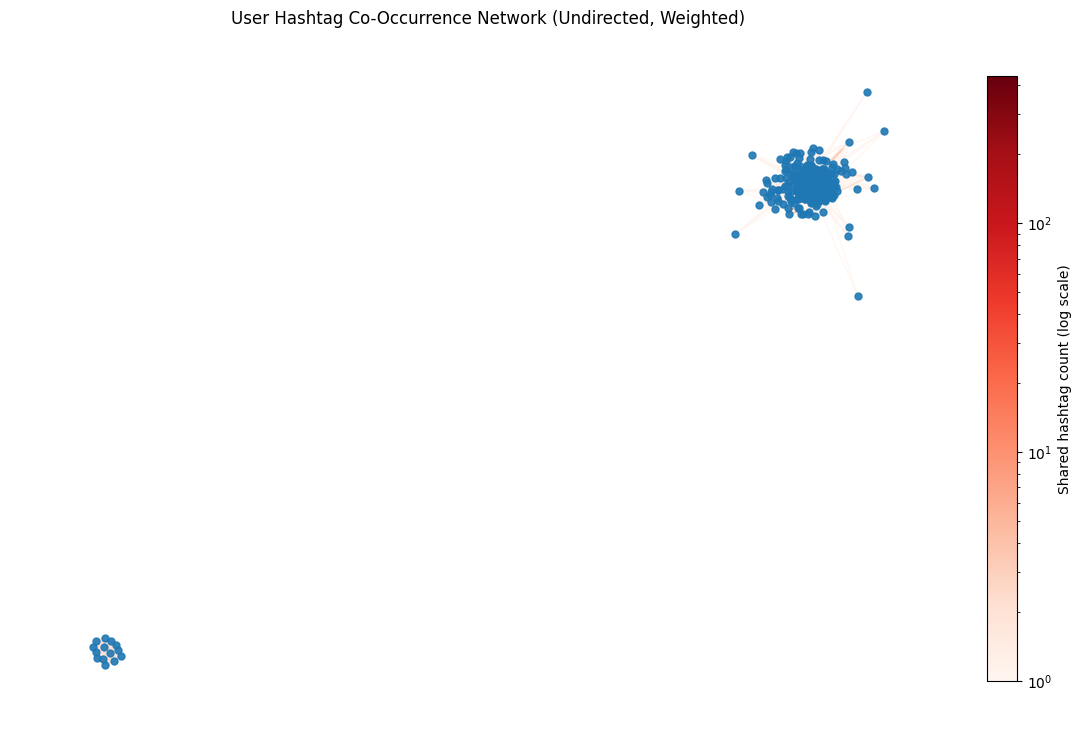

In [15]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import combinations
import ast

df = df_tweets.copy()

df["tweet_id"] = df["tweet_id"].astype(str).str.strip()
df["user_id"] = df["user_id"].astype(str).str.strip().str.replace(r"\.0$", "", regex=True)

def normalize_hashtags(x):
    if x is None:
        return []
    try:
        if pd.isna(x):
            return []
    except Exception:
        pass

    if isinstance(x, (list, tuple, set, np.ndarray)):
        tags = list(x)
    else:
        s = str(x).strip()
        if s == "" or s.lower() in {"nan", "none", "<na>"}:
            return []
        if s.startswith("[") and s.endswith("]"):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, (list, tuple, set)):
                    tags = list(parsed)
                else:
                    tags = [parsed]
            except Exception:
                tags = [s]
        else:
            tags = [s]

    out = []
    for t in tags:
        if t is None:
            continue
        st = str(t).strip().lstrip("#").lower()
        if st and st not in {"nan", "none", "<na>"}:
            out.append(st)

    return sorted(set(out))

df["hashtags_norm"] = df["hashtags"].apply(normalize_hashtags) if "hashtags" in df.columns else [[]] * len(df)

user_tags = (
    df.loc[df["hashtags_norm"].map(len) > 0, ["user_id", "hashtags_norm"]]
    .explode("hashtags_norm")
    .rename(columns={"hashtags_norm": "hashtag"})
    .dropna(subset=["hashtag"])
)

tag_to_users = (
    user_tags[["hashtag", "user_id"]]
    .drop_duplicates()
    .groupby("hashtag")["user_id"]
    .apply(list)
)

pairs = []
for users_list in tag_to_users:
    if len(users_list) >= 2:
        for u, v in combinations(sorted(users_list), 2):
            pairs.append((u, v))

if len(pairs) == 0:
    G = nx.Graph()
else:
    counts = (
        pd.DataFrame(pairs, columns=["user_u", "user_v"])
        .value_counts()
        .reset_index(name="weight")
    )

    G = nx.Graph()
    for u, v, w in counts.itertuples(index=False):
        G.add_edge(u, v, weight=int(w))

def plot_weighted_graph_undirected(G: nx.Graph, title: str, seed: int = 42, k: float | None = None):
    fig, ax = plt.subplots(figsize=(13, 9))

    if G.number_of_nodes() == 0 or G.number_of_edges() == 0:
        ax.set_title(title)
        ax.axis("off")
        plt.show()
        return

    pos = nx.spring_layout(G, seed=seed, k=k)

    weights = np.array([G[u][v].get("weight", 1) for u, v in G.edges()], dtype=float)
    w_min, w_max = max(1.0, float(weights.min())), float(weights.max())

    norm = mpl.colors.LogNorm(vmin=w_min, vmax=w_max)
    cmap = plt.cm.Reds
    edge_colors = cmap(norm(weights))

    if w_max > w_min:
        edge_widths = 0.8 + 3.2 * (np.log(weights) - np.log(w_min)) / (np.log(w_max) - np.log(w_min))
    else:
        edge_widths = np.full_like(weights, 2.0)

    nx.draw_networkx_nodes(G, pos, node_size=25, alpha=0.9, ax=ax)
    nx.draw_networkx_edges(
        G, pos,
        width=edge_widths,
        edge_color=edge_colors,
        alpha=0.95,
        ax=ax
    )

    ax.set_title(title)
    ax.axis("off")

    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_label("Shared hashtag count (log scale)")

    plt.show()

plot_weighted_graph_undirected(G, "User Hashtag Co-Occurrence Network (Undirected, Weighted)")


In [16]:
import pandas as pd
import numpy as np
import networkx as nx
from collections import Counter, defaultdict

# Assumes you already built:
# - df (copy of df_tweets with df["hashtags_norm"])
# - user_tags (columns: user_id, hashtag)
# - G (undirected hashtag co-occurrence graph)

components = list(nx.connected_components(G))
components = sorted(components, key=len, reverse=True)

print("=" * 90)
print(f"#nodes: {G.number_of_nodes()} | #edges: {G.number_of_edges()}")
print(f"#connected components: {len(components)}")
print("Component sizes:", [len(c) for c in components[:10]])
print("=" * 90)

# Map user -> set(hashtags)
user_to_tags = (
    user_tags.groupby("user_id")["hashtag"]
    .apply(lambda s: set(s.dropna().astype(str)))
    .to_dict()
)

def component_hashtag_counter(nodes):
    c = Counter()
    for u in nodes:
        for h in user_to_tags.get(u, set()):
            c[h] += 1
    return c

# Show "signature" hashtags for the two largest components
if len(components) >= 2:
    C1 = components[0]
    C2 = components[1]

    h1 = component_hashtag_counter(C1)
    h2 = component_hashtag_counter(C2)

    print("\n" + "-" * 90)
    print(f"Component #1 size = {len(C1)} | top hashtags (by #users in component using it):")
    for tag, cnt in h1.most_common(15):
        print(f"  {tag:<25} {cnt}")

    print("\n" + "-" * 90)
    print(f"Component #2 size = {len(C2)} | top hashtags (by #users in component using it):")
    for tag, cnt in h2.most_common(15):
        print(f"  {tag:<25} {cnt}")

    # Check overlap in hashtag vocab between the two components
    vocab1 = set(h1.keys())
    vocab2 = set(h2.keys())
    overlap = vocab1 & vocab2

    print("\n" + "-" * 90)
    print(f"Hashtag vocab overlap between component #1 and #2: {len(overlap)} hashtags")
    if len(overlap) > 0:
        print("Example overlapping hashtags:", list(sorted(overlap))[:30])

    # Identify hashtags that are highly specific to each component
    # score = fraction of users using hashtag inside component vs outside
    all_users = set(G.nodes())
    outside1 = all_users - set(C1)
    outside2 = all_users - set(C2)

    def specificity_scores(comp_nodes, outside_nodes, topn=15, min_in=3):
        in_count = component_hashtag_counter(comp_nodes)
        out_count = component_hashtag_counter(outside_nodes)

        scores = []
        for tag, cnt_in in in_count.items():
            if cnt_in < min_in:
                continue
            cnt_out = out_count.get(tag, 0)
            # +1 smoothing to avoid div by zero
            score = (cnt_in / max(1, len(comp_nodes))) / ((cnt_out + 1) / max(1, len(outside_nodes)))
            scores.append((tag, cnt_in, cnt_out, score))

        scores.sort(key=lambda x: x[3], reverse=True)
        return scores[:topn]

    print("\n" + "-" * 90)
    print("Most component-specific hashtags for Component #1:")
    for tag, cnt_in, cnt_out, score in specificity_scores(C1, outside1):
        print(f"  {tag:<25} in:{cnt_in:<4} out:{cnt_out:<4} specificity:{score:.2f}")

    print("\n" + "-" * 90)
    print("Most component-specific hashtags for Component #2:")
    for tag, cnt_in, cnt_out, score in specificity_scores(C2, outside2):
        print(f"  {tag:<25} in:{cnt_in:<4} out:{cnt_out:<4} specificity:{score:.2f}")

else:
    print("Graph has <2 components; the plot separation might be layout artifacts.")


#nodes: 340 | #edges: 34356
#connected components: 2
Component sizes: [326, 14]

------------------------------------------------------------------------------------------
Component #1 size = 326 | top hashtags (by #users in component using it):
  trump                     200
  imwithher                 131
  clinton                   119
  electionday               111
  hillaryclinton            102
  nevertrump                98
  maga                      98
  debate                    96
  rncincle                  92
  blacklivesmatter          90
  election2016              88
  debatenight               88
  obama                     85
  gop                       83
  neverhillary              78

------------------------------------------------------------------------------------------
Component #2 size = 14 | top hashtags (by #users in component using it):
  imwithhumusmarshmallowspeanutbuttersteakribeye 14
  imwithchickenavocadosubwaydressedwithsweetonionanddoublehoneymust

Removed hashtags: ['imwithchickenavocadosubwaydressedwithsweetonionanddoublehoneymustard', 'imwithhumusmarshmallowspeanutbuttersteakribeye']
Graph after removal: nodes=326 edges=34265 components=1


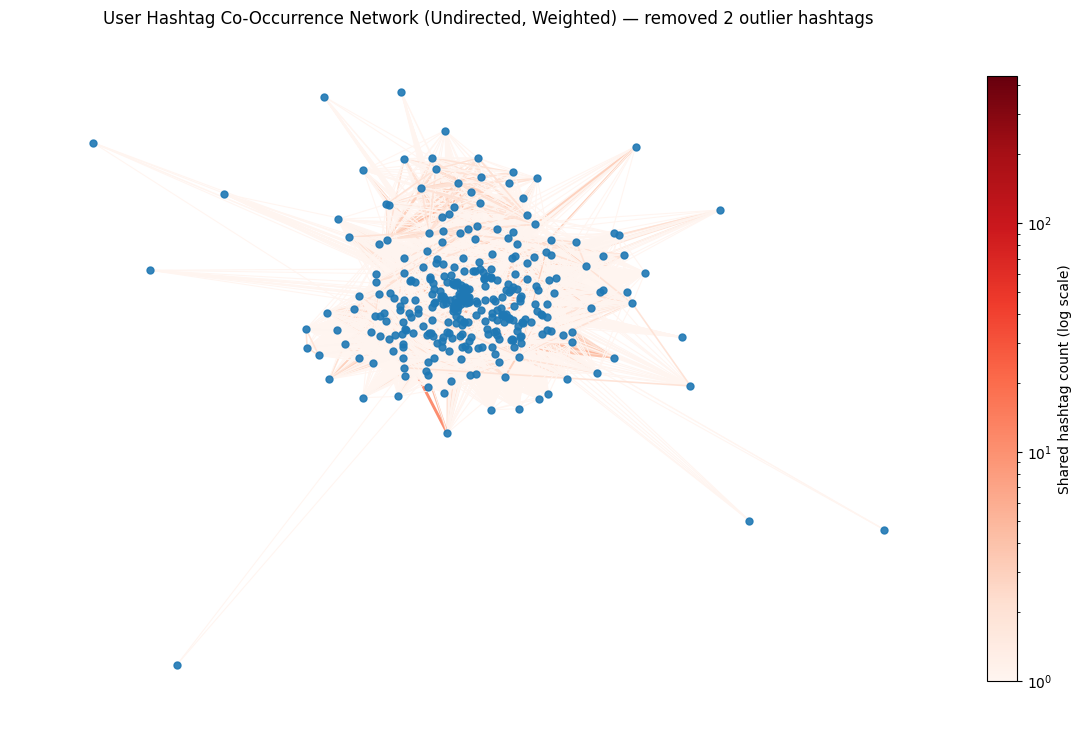

In [17]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import combinations
import ast

df = df_tweets.copy()

df["tweet_id"] = df["tweet_id"].astype(str).str.strip()
df["user_id"] = df["user_id"].astype(str).str.strip().str.replace(r"\.0$", "", regex=True)

REMOVE_TAGS = {
    "imwithhumusmarshmallowspeanutbuttersteakribeye",
    "imwithchickenavocadosubwaydressedwithsweetonionanddoublehoneymustard",
}

def normalize_hashtags(x):
    if x is None:
        return []
    try:
        if pd.isna(x):
            return []
    except Exception:
        pass

    if isinstance(x, (list, tuple, set, np.ndarray)):
        tags = list(x)
    else:
        s = str(x).strip()
        if s == "" or s.lower() in {"nan", "none", "<na>"}:
            return []
        if s.startswith("[") and s.endswith("]"):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, (list, tuple, set)):
                    tags = list(parsed)
                else:
                    tags = [parsed]
            except Exception:
                tags = [s]
        else:
            tags = [s]

    out = []
    for t in tags:
        if t is None:
            continue
        st = str(t).strip().lstrip("#").lower()
        if st and st not in {"nan", "none", "<na>"} and st not in REMOVE_TAGS:
            out.append(st)

    return sorted(set(out))

df["hashtags_norm"] = df["hashtags"].apply(normalize_hashtags) if "hashtags" in df.columns else [[]] * len(df)

user_tags = (
    df.loc[df["hashtags_norm"].map(len) > 0, ["user_id", "hashtags_norm"]]
    .explode("hashtags_norm")
    .rename(columns={"hashtags_norm": "hashtag"})
    .dropna(subset=["hashtag"])
)

tag_to_users = (
    user_tags[["hashtag", "user_id"]]
    .drop_duplicates()
    .groupby("hashtag")["user_id"]
    .apply(list)
)

pairs = []
for users_list in tag_to_users:
    if len(users_list) >= 2:
        for u, v in combinations(sorted(users_list), 2):
            pairs.append((u, v))

if len(pairs) == 0:
    G = nx.Graph()
else:
    counts = (
        pd.DataFrame(pairs, columns=["user_u", "user_v"])
        .value_counts()
        .reset_index(name="weight")
    )

    G = nx.Graph()
    for u, v, w in counts.itertuples(index=False):
        G.add_edge(u, v, weight=int(w))

def plot_weighted_graph_undirected(G: nx.Graph, title: str, seed: int = 42, k: float | None = None):
    fig, ax = plt.subplots(figsize=(13, 9))

    if G.number_of_nodes() == 0 or G.number_of_edges() == 0:
        ax.set_title(title)
        ax.axis("off")
        plt.show()
        return

    pos = nx.spring_layout(G, seed=seed, k=k)

    weights = np.array([G[u][v].get("weight", 1) for u, v in G.edges()], dtype=float)
    w_min, w_max = max(1.0, float(weights.min())), float(weights.max())

    norm = mpl.colors.LogNorm(vmin=w_min, vmax=w_max)
    cmap = plt.cm.Reds
    edge_colors = cmap(norm(weights))

    if w_max > w_min:
        edge_widths = 0.8 + 3.2 * (np.log(weights) - np.log(w_min)) / (np.log(w_max) - np.log(w_min))
    else:
        edge_widths = np.full_like(weights, 2.0)

    nx.draw_networkx_nodes(G, pos, node_size=25, alpha=0.9, ax=ax)
    nx.draw_networkx_edges(
        G, pos,
        width=edge_widths,
        edge_color=edge_colors,
        alpha=0.95,
        ax=ax
    )

    ax.set_title(title)
    ax.axis("off")

    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_label("Shared hashtag count (log scale)")

    plt.show()

print("Removed hashtags:", sorted(REMOVE_TAGS))
print(f"Graph after removal: nodes={G.number_of_nodes()} edges={G.number_of_edges()} components={nx.number_connected_components(G)}")

plot_weighted_graph_undirected(G, "User Hashtag Co-Occurrence Network (Undirected, Weighted) — removed 2 outlier hashtags")


In [18]:
df_tweets.columns

Index(['user_id', 'user_key', 'created_at', 'created_str', 'retweet_count',
       'retweeted', 'favorite_count', 'text', 'tweet_id', 'source', 'hashtags',
       'expanded_urls', 'posted', 'mentions', 'retweeted_status_id',
       'in_reply_to_status_id'],
      dtype='object')

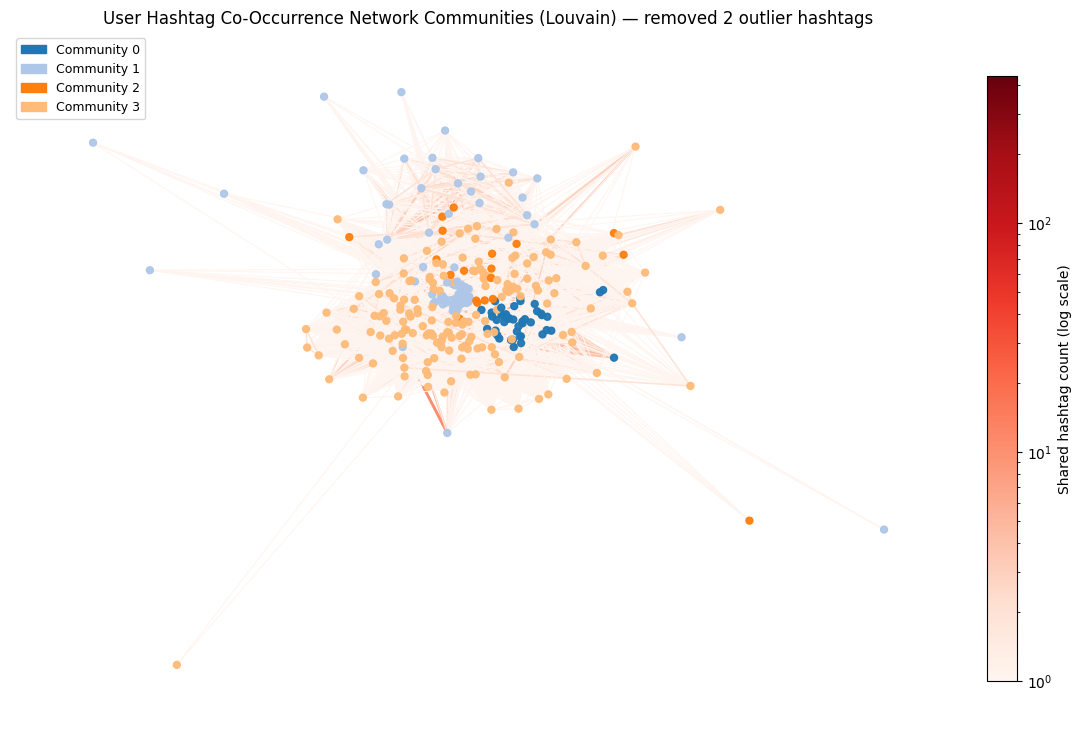

In [19]:
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx

def plot_weighted_graph_undirected_with_communities(
    G: nx.Graph,
    community_map: dict,
    title: str,
    seed: int = 42,
    k: float | None = None
):
    fig, ax = plt.subplots(figsize=(13, 9))

    if G.number_of_nodes() == 0 or G.number_of_edges() == 0:
        ax.set_title(title)
        ax.axis("off")
        plt.show()
        return

    pos = nx.spring_layout(G, seed=seed, k=k)

    weights = np.array([G[u][v].get("weight", 1) for u, v in G.edges()], dtype=float)
    w_min, w_max = max(1.0, float(weights.min())), float(weights.max())

    norm = mpl.colors.LogNorm(vmin=w_min, vmax=w_max)
    edge_colors = plt.cm.Reds(norm(weights))

    if w_max > w_min:
        edge_widths = 0.8 + 3.2 * (np.log(weights) - np.log(w_min)) / (np.log(w_max) - np.log(w_min))
    else:
        edge_widths = np.full_like(weights, 2.0)

    communities = sorted(set(community_map.values()))
    cmap_nodes = plt.cm.tab20
    color_lookup = {cid: cmap_nodes(cid % cmap_nodes.N) for cid in communities}

    node_colors = [color_lookup.get(community_map.get(n), (0.5, 0.5, 0.5, 1.0)) for n in G.nodes()]

    nx.draw_networkx_nodes(
        G, pos,
        node_size=25,
        node_color=node_colors,
        alpha=0.95,
        ax=ax
    )
    nx.draw_networkx_edges(
        G, pos,
        width=edge_widths,
        edge_color=edge_colors,
        alpha=0.95,
        ax=ax
    )

    legend_handles = [
        mpatches.Patch(color=color_lookup[cid], label=f"Community {cid}")
        for cid in communities
    ]
    ax.legend(
        handles=legend_handles,
        loc="upper left",
        frameon=True,
        fontsize=9
    )

    ax.set_title(title)
    ax.axis("off")

    sm = mpl.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_label("Shared hashtag count (log scale)")

    plt.show()

plot_weighted_graph_undirected_with_communities(
    G,
    community_map,
    f"User Hashtag Co-Occurrence Network Communities ({method}) — removed 2 outlier hashtags"
)


In [20]:
df_users = pd.read_csv("users.csv")

In [21]:
import pandas as pd
import networkx as nx
from collections import defaultdict
import textwrap

users = df_users.copy()
users["id"] = users["id"].astype(str).str.strip().str.replace(r"\.0$", "", regex=True)

meta = (
    users[["id", "description"]]
    .drop_duplicates("id")
    .set_index("id")
)

def is_missing(x):
    if x is None:
        return True
    try:
        if pd.isna(x):
            return True
    except Exception:
        pass
    s = str(x).strip()
    return s == "" or s.lower() in {"nan", "none", "<na>"}

def internal_weighted_degree_undirected(subG, u):
    return int(sum(d.get("weight", 1) for _, _, d in subG.edges(u, data=True)))

community_nodes = defaultdict(list)
for node, cid in community_map.items():
    community_nodes[cid].append(node)

top6 = sorted(community_nodes.items(), key=lambda x: len(x[1]), reverse=True)[:6]

community_blocks = []
for idx, (cid, nodes) in enumerate(top6, start=1):
    sub = G.subgraph(nodes)
    ranked = sorted(
        nodes,
        key=lambda u: internal_weighted_degree_undirected(sub, u),
        reverse=True
    )

    block = [f"Community {idx} (cid={cid})"]
    count = 0
    for u in ranked:
        if u in meta.index:
            desc = meta.loc[u, "description"]
            if not is_missing(desc):
                block.append(f"{u} : {str(desc).strip()}")
                count += 1
        if count >= 10:
            break

    if count == 0:
        block.append("[no descriptions available]")

    community_blocks.append(block)

def format_block(block_lines, width):
    out = []
    for line in block_lines:
        wrapped = textwrap.wrap(line, width=width) or [""]
        out.extend(wrapped)
    return out

def print_grid(blocks, cols=3, width=65):
    rows = (len(blocks) + cols - 1) // cols
    blocks = blocks + [[]] * (rows * cols - len(blocks))
    formatted = [format_block(b, width) for b in blocks]

    for r in range(rows):
        row_blocks = formatted[r*cols:(r+1)*cols]
        max_h = max(len(b) for b in row_blocks)

        padded = [b + [""] * (max_h - len(b)) for b in row_blocks]

        for i in range(max_h):
            print(" | ".join(padded[c][i].ljust(width) for c in range(cols)))

        if r != rows - 1:
            print("-" * (cols * width + (cols - 1) * 3))

print_grid(community_blocks, cols=3, width=65)


Community 1 (cid=3)                                               | Community 2 (cid=1)                                               | Community 3 (cid=0)                                              
1659549972 : I`m studing to earn much money in the future and i`m | 1679279490 : Wife, Mother, Patriot, Friend                        | 1727482238 : Internet junkie #hashtagwars lover!                 
working to earn money for studing...                              | 1671234620 : ~Reagan Conservative ~Jesus Lover ~PRO-Israel        | 2533001646 : #hashtagwarrior and your mom knows it!              
1658420976 : When I let go of what I am, I become what I might    | ~PRO-2A ~PRO-Life ~PRO-Constitution ~Support Police & Military    | 2531159968 : Great thoughts speak only to the thoughtful mind,   
be.                                                               | #RenewUS #PJNET #TCOT #CruzCrew #WakeUpAmerica                    | but great actions speak to all mankind.                 

In [22]:
from networkx.algorithms.community import louvain_communities

communities = louvain_communities(G, weight="weight", seed=42)

community_map = {}
for cid, comm in enumerate(communities):
    for u in comm:
        community_map[u] = cid


communities = louvain_communities(G, weight="weight")


In [23]:
import pandas as pd
import numpy as np
import networkx as nx
import ast
from itertools import combinations

REMOVE_TAGS = {
    "imwithhumusmarshmallowspeanutbuttersteakribeye",
    "imwithchickenavocadosubwaydressedwithsweetonionanddoublehoneymustard",
}

df = df_tweets.copy()
df["user_id"] = df["user_id"].astype(str).str.replace(r"\.0$", "", regex=True)

def normalize_hashtags(x):
    if pd.isna(x):
        return []
    if isinstance(x, (list, tuple)):
        tags = x
    else:
        try:
            tags = ast.literal_eval(str(x))
            if not isinstance(tags, (list, tuple)):
                tags = [tags]
        except Exception:
            tags = [str(x)]
    return sorted({
        str(t).lower().lstrip("#")
        for t in tags
        if str(t).lower().lstrip("#") not in REMOVE_TAGS
    })

df["hashtags_norm"] = df["hashtags"].apply(normalize_hashtags)

user_tags = (
    df.explode("hashtags_norm")[["user_id", "hashtags_norm"]]
    .dropna()
    .drop_duplicates()
)

tag_to_users = user_tags.groupby("hashtags_norm")["user_id"].apply(list)

pairs = []
for users in tag_to_users:
    if len(users) > 1:
        for u, v in combinations(sorted(users), 2):
            pairs.append((u, v))

edges = (
    pd.DataFrame(pairs, columns=["u", "v"])
    .value_counts()
    .reset_index(name="weight")
)

G = nx.Graph()
for u, v, w in edges.itertuples(index=False):
    G.add_edge(u, v, weight=w)

print("nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())



nodes: 326 edges: 34265


In [28]:
import textwrap

if "hashtag" not in user_tags.columns:
    user_tags = user_tags.rename(columns={"hashtags_norm": "hashtag"})

community_ids = sorted(set(community_map.values()))
communities = [
    set(n for n, cid in community_map.items() if cid == com_id)
    for com_id in community_ids
]

def top_hashtags_for_community(members, k=15):
    return (
        user_tags[user_tags["user_id"].isin(members)]
        .groupby("hashtag")["user_id"]
        .nunique()
        .sort_values(ascending=False)
        .head(k)
    )

blocks = []
for cid, members in enumerate(communities):
    tags = top_hashtags_for_community(members)
    lines = [f"COMMUNITY {cid} | size={len(members)}"]
    for tag, cnt in tags.items():
        lines.append(f"{tag} ({cnt})")
    blocks.append(lines)

def format_blocks_row(blocks, width=40):
    max_h = max(len(b) for b in blocks)
    padded = [b + [""] * (max_h - len(b)) for b in blocks]

    for i in range(max_h):
        print(" | ".join(padded[j][i].ljust(width) for j in range(len(blocks))))

print("=" * (4 * 40 + 9))
format_blocks_row(blocks, width=40)
print("=" * (4 * 40 + 9))


COMMUNITY 0 | size=46                    | COMMUNITY 1 | size=87                    | COMMUNITY 2 | size=19                    | COMMUNITY 3 | size=174                  
trumpsfavoriteheadline (41)              | tcot (53)                                | makeamericagreatagain (13)               | trump (112)                             
igetdepressedwhen (39)                   | maga (53)                                | demsinphilly (12)                        | clinton (67)                            
mustbebanned (38)                        | trump (52)                               | dncleak (11)                             | rncincle (60)                           
betteralternativetodebates (37)          | hillaryclinton (52)                      | demconvention (11)                       | imwithher (46)                          
rejecteddebatetopics (37)                | pjnet (51)                               | neverhillary (10)                        | electionday (46)     

In [29]:
df_tweets.shape

(203451, 16)

In [30]:
df_users.shape

(453, 14)